In [1]:
using Distributed
addprocs(44);

In [2]:
using pulse_input_DDM

In [3]:
path = "/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

"/usr/people/briandd/Projects/neural_DDM_analysis/data/hanks_data_sessions"

In [4]:
#ratnames = ["B068","T034","T036","T063","T030"] #FOF
#ratnames = ["T035","T011","B053"] PPC
#ratnames = ["T080","T103","E021"] #STR

In [85]:
region, rat = "FOF", "T063"

("FOF", "T063")

In [86]:
sessions = filter(x->occursin(rat,x), readdir(path))

17-element Array{String,1}:
 "T063_191956.mat"
 "T063_193936.mat"
 "T063_194554.mat"
 "T063_194649.mat"
 "T063_194770.mat"
 "T063_194898.mat"
 "T063_195271.mat"
 "T063_195546.mat"
 "T063_195676.mat"
 "T063_195791.mat"
 "T063_196336.mat"
 "T063_196580.mat"
 "T063_196708.mat"
 "T063_197075.mat"
 "T063_197212.mat"
 "T063_197479.mat"
 "T063_198004.mat"

In [224]:
output = load.(joinpath.(path, sessions), false, delay=0.0);

In [225]:
data = getindex.(output, 1)
μ_rnt = getindex.(output, 2);
μ_t = getindex.(output, 3);

In [226]:
f, ncells, ntrials, nparams = "Sigmoid", map(x-> x[1].ncells, data), length.(data), 4

("Sigmoid", [1, 1, 2, 1, 1, 1, 2, 1, 4, 1, 3, 3, 4, 3, 2, 1, 3], [199, 188, 190, 183, 249, 195, 161, 259, 198, 219, 263, 257, 264, 249, 300, 319, 309], 4)

In [227]:
nconds, dt, n = 2, 1e-2, 53

(2, 0.01, 53)

In [228]:
output = pulse_input_DDM.process_spike_data.(μ_rnt, data, ncells; nconds=nconds);

μ_ct = getindex.(output, 1)
σ_ct = getindex.(output, 2);

In [229]:
using PyPlot

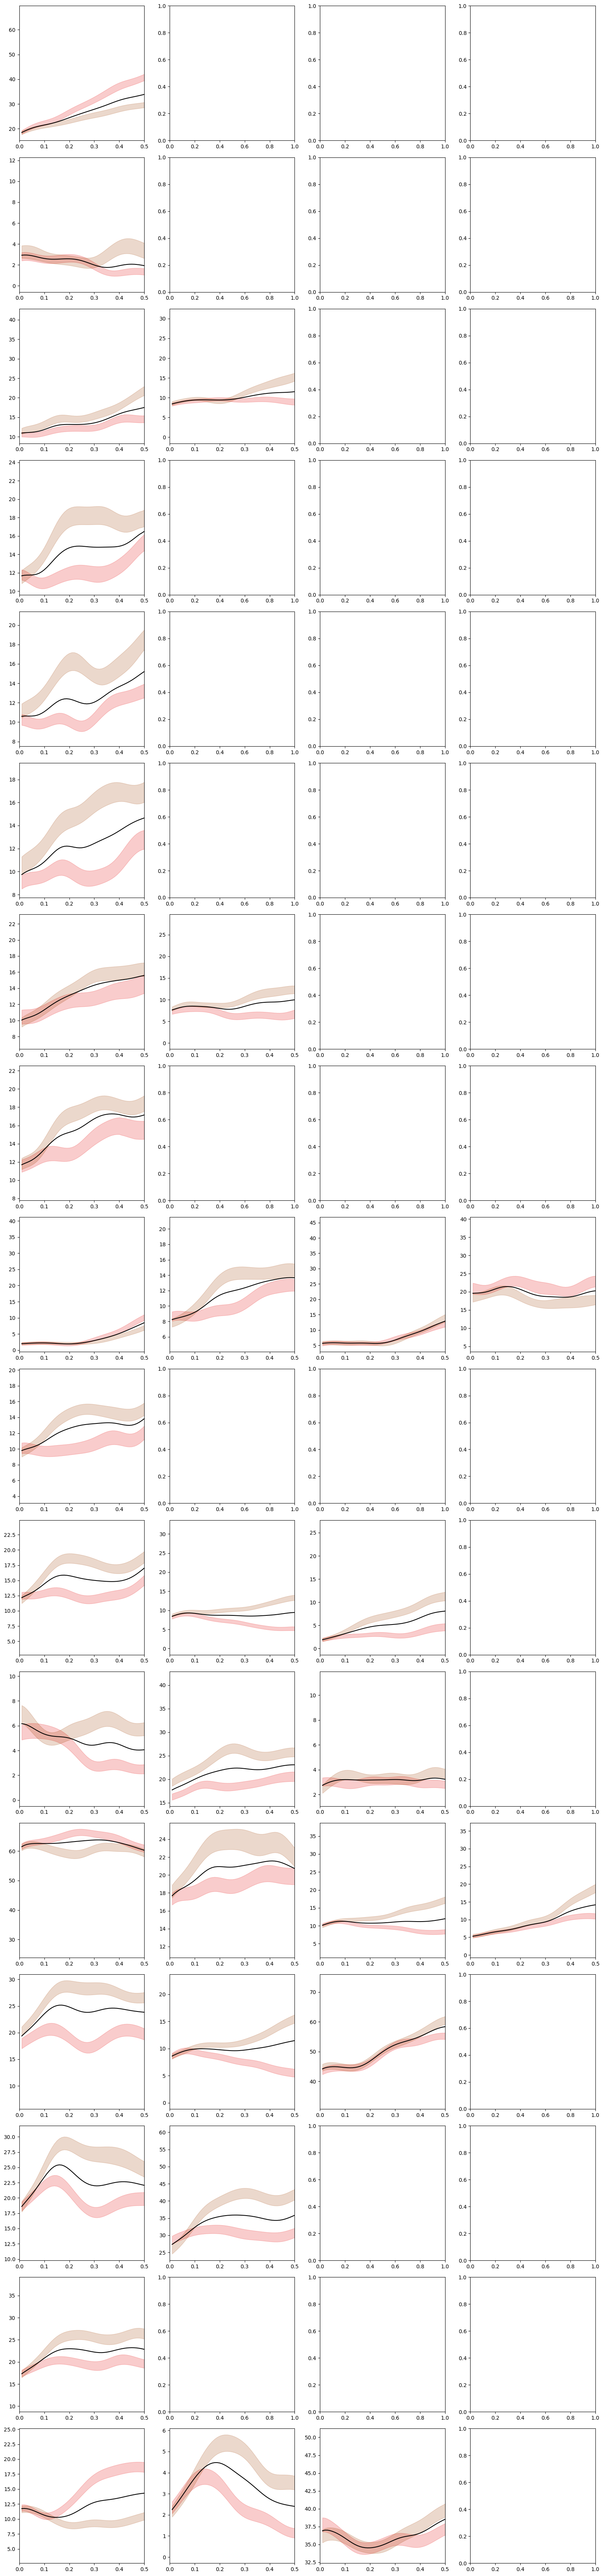

In [230]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]
#PPC colors = ["#1822A0","#5D4A7A","#A37354","#E99C2F"]
#STR colors = ["#A01892","#B85C71","#D0A150","#E9E62F"]

for i in 1:num_rows      
    for j in 1:data[i][1].ncells   
        
        if (num_rows == 1) && (data[i][1].ncells == 1)
        
            for k = 1:nconds   

                ax.fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])                                   

                ax.set_xlim((0, 0.5))

            end   

            ax.plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
            
        elseif (num_rows == 1) && (data[i][1].ncells > 1)
            
            for k = 1:nconds   

                ax[j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])                                  

                ax[j].set_xlim((0, 0.5))

            end   

            ax[j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        elseif num_rows > 1
             
            for k = 1:nconds   

                ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])                                   

                ax[i,j].set_xlim((0, 0.5))

            end   

            ax[i,j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        end

    end
    
end

tight_layout() 

## Fit

In [94]:
θy0 = vcat(vcat(initialize_θy.(data, f)...)...);

In [95]:
options0 = neuraloptions(ncells=ncells,
    fit=vcat(falses(dimz), trues(sum(ncells)*nparams)),
    x0=vcat([0., 30., 0. + eps(), 0., 0., 1. - eps(), 0.008], θy0))

neuraloptions
  ncells: Array{Int64}((17,)) [1, 1, 2, 1, 1, 1, 2, 1, 4, 1, 3, 3, 4, 3, 2, 1, 3]
  nparams: Int64 4
  f: String "Sigmoid"
  fit: Array{Bool}((143,)) Bool[0, 0, 0, 0, 0, 0, 0, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  lb: Array{Float64}((143,)) [0.0, 8.0, -5.0, 0.0, 0.0, 0.01, 0.005, -100.0, 0.0, -10.0  …  -10.0, -10.0, -100.0, 0.0, -10.0, -10.0, -100.0, 0.0, -10.0, -10.0]
  ub: Array{Float64}((143,)) [30.0, 32.0, 5.0, 200.0, 5.0, 1.2, 1.0, 100.0, 100.0, 10.0  …  10.0, 10.0, 100.0, 100.0, 10.0, 10.0, 100.0, 100.0, 10.0, 10.0]
  x0: Array{Float64}((143,)) [0.0, 30.0, 2.220446049250313e-16, 0.0, 0.0, 0.9999999999999998, 0.008, 25.436757512229207, 44.93361285814116, -0.00244743378860693  …  -0.002245340779347089, 0.0, 0.1, 3.9404951169657054, 0.0005687069143647916, 0.0, 36.29113575946466, 9.71525401689317, 0.001225733958446602, 0.0]


In [96]:
model, = optimize(data, options0; show_trace=false)

optimization complete. converged: true 



(neuralDDM{θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}},Array{Array{neuraldata,1},1}}
  θ: θneural{θz{Float64},Array{Array{Sigmoid{Float64},1},1}}
  data: Array{Array{neuraldata,1}}((17,))
,  * Status: success

 * Candidate solution
    Minimizer: [-3.73e-01, 4.47e+01, -2.29e-03,  ...]
    Minimum:   3.195141e+05

 * Found with
    Algorithm:     Fminbox with BFGS
    Initial Point: [2.54e+01, 4.49e+01, -2.45e-03,  ...]

 * Convergence measures
    |x - x'|               = 1.01e-01 ≰ 1.0e-10
    |x - x'|/|x'|          = 1.07e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.63e-01 ≰ 1.0e-06
    |f(x) - f(x')|/|f(x')| = 8.22e-07 ≰ 0.0e+00
    |g(x)|                 = 1.16e+00 ≰ 1.0e-03

 * Work counters
    Seconds run:   347  (vs limit Inf)
    Iterations:    2
    f(x) calls:    240
    ∇f(x) calls:   55
)

In [97]:
model.θ.θy

17-element Array{Array{Sigmoid{Float64},1},1}:
 [Sigmoid{Float64}
  a: Float64 -0.3725658746460133
  b: Float64 44.69193955836141
  c: Float64 -0.0022929126340666666
  d: Float64 -4.5207155898092815
]                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
 [Sigmoid{Float64}
  a: Float64 -2.2813876698743054
  b: Float64 2.1236547021864305
  c: Float64 0.0005033369423707108
  d: Float64 8.240904515994329
]                                                                                                                                                                                                    

In [98]:
fit=vcat(falses(1), trues(dimz-1), trues(sum(ncells)*nparams))
#x0=vcat([0.1, 12., -2., 10., 0.1, 0.8, 0.008], θy0);
x0=vcat([0.1, 12., -2., 10., 0.1, 0.8, 0.008], pulse_input_DDM.flatten(model.θ)[dimz+1:end]);

In [99]:
options = neuraloptions(ncells=ncells, x0=x0, fit=fit, nparams=nparams, f=f);

In [100]:
model, = optimize(data, options, n);

Fminbox
-------
Initial mu = 0.0146642

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0146642

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     3.194914e+05     1.162483e+03
 * time: 5.316734313964844e-5
     1     3.193385e+05     8.720934e+02
 * time: 72.84959411621094
     2     3.193372e+05     8.701868e+02
 * time: 146.66222715377808
     3     3.193289e+05     3.600732e+05
 * time: 219.62625813484192
     4     3.191025e+05     6.058997e+03
 * time: 291.93992805480957
     5     3.190096e+05     6.452829e+03
 * time: 365.59463119506836
     6     3.189858e+05     6.096058e+03
 * time: 438.50705122947693
     7     3.189725e+05     5.971356e+03
 * time: 510.8252820968628
     8     3.189718e+05     5.965311e+03
 * time: 583.841292142868
     9     3.189470e+05     6.478584e+03
 * time: 656.4771451950073
    10     3.189455e+05     6.487905e+03
 * time: 730.4480240345001
    11     3.188625e+05     4.1642

   117     3.166057e+05     4.269247e+03
 * time: 9228.681296110153
   118     3.165972e+05     4.290041e+03
 * time: 9295.432908058167
   119     3.165895e+05     4.387401e+03
 * time: 9361.973204135895
   120     3.165886e+05     4.387021e+03
 * time: 9429.293389081955
   121     3.165817e+05     4.668083e+03
 * time: 9563.391341209412
   122     3.165721e+05     4.522557e+03
 * time: 9663.89223909378
   123     3.165562e+05     4.690939e+03
 * time: 9765.729006052017
   124     3.165369e+05     4.835839e+03
 * time: 9866.752778053284
   125     3.165280e+05     4.783022e+03
 * time: 9934.239017009735
   126     3.165220e+05     4.708848e+03
 * time: 10035.104368209839
   127     3.165171e+05     4.660359e+03
 * time: 10135.616228103638
   128     3.165084e+05     4.577953e+03
 * time: 10236.725580215454
   129     3.164980e+05     4.489643e+03
 * time: 10337.195437192917
   130     3.164886e+05     4.359043e+03
 * time: 10437.80755019188
   131     3.164788e+05     4.790452e+03
 * t

   237     3.160408e+05     3.524270e+02
 * time: 19509.312965154648
   238     3.160374e+05     3.413825e+02
 * time: 19617.399214029312
   239     3.160348e+05     1.421752e+02
 * time: 19689.297394037247
   240     3.160319e+05     1.655242e+02
 * time: 19761.24430704117
   241     3.160282e+05     2.092005e+02
 * time: 19869.17786502838
   242     3.160257e+05     2.476307e+02
 * time: 19977.339938163757
   243     3.160203e+05     3.371054e+02
 * time: 20085.061209201813
   244     3.160162e+05     3.907491e+02
 * time: 20157.482968091965
   245     3.160110e+05     4.446955e+02
 * time: 20265.652647018433
   246     3.160069e+05     4.836200e+02
 * time: 20373.765582084656
   247     3.160021e+05     4.058916e+02
 * time: 20446.535815000534
   248     3.159966e+05     5.338927e+02
 * time: 20520.18674015999
   249     3.159938e+05     3.330741e+04
 * time: 20592.150989055634
   250     3.159911e+05     2.403191e+02
 * time: 20664.20979309082
   251     3.159898e+05     2.314186e+

   357     3.158266e+05     1.387480e+02
 * time: 31127.08221411705
   358     3.158253e+05     1.755062e+02
 * time: 31199.845514059067
   359     3.158244e+05     1.431856e+02
 * time: 31272.92864203453
   360     3.158236e+05     3.146416e+02
 * time: 31346.127333164215
   361     3.158230e+05     1.157520e+02
 * time: 31419.045736074448
   362     3.158225e+05     1.091440e+02
 * time: 31491.624481201172
   363     3.158220e+05     1.413857e+02
 * time: 31563.94327712059
   364     3.158212e+05     1.199124e+02
 * time: 31673.577577114105
   365     3.158204e+05     8.350264e+01
 * time: 31782.765272140503
   366     3.158201e+05     7.364089e+01
 * time: 31891.81211209297
   367     3.158195e+05     7.385623e+01
 * time: 32001.40311217308
   368     3.158190e+05     7.412742e+01
 * time: 32110.75549006462
   369     3.158183e+05     9.659628e+01
 * time: 32221.020837068558
   370     3.158183e+05     1.728122e+02
 * time: 32294.13388800621
   371     3.158179e+05     2.167829e+02


   478     3.158084e+05     6.367269e+01
 * time: 40339.79882001877
   479     3.158083e+05     6.357504e+01
 * time: 40413.39583611488
   480     3.158083e+05     2.707204e+01
 * time: 40485.477524995804
   481     3.158082e+05     4.834967e+01
 * time: 40557.95381808281
   482     3.158082e+05     2.612444e+01
 * time: 40631.30435299873
   483     3.158081e+05     2.560446e+01
 * time: 40703.98546719551
   484     3.158081e+05     2.516887e+01
 * time: 40776.60987305641
   485     3.158080e+05     2.781432e+01
 * time: 40849.85032916069
   486     3.158080e+05     2.869755e+01
 * time: 40922.2566781044
   487     3.158079e+05     4.419053e+01
 * time: 40994.08507514
   488     3.158078e+05     2.231526e+01
 * time: 41067.02572917938
   489     3.158078e+05     3.394456e+01
 * time: 41139.85685300827
   490     3.158078e+05     4.499971e+01
 * time: 41211.98872208595
   491     3.158077e+05     2.132306e+01
 * time: 41284.406932115555
   492     3.158077e+05     2.642352e+01
 * time: 

Fminbox iteration 2
-------------------
Calling inner optimizer with mu = 1.46642e-5

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     3.158198e+05     2.980199e+00
 * time: 4.696846008300781e-5
     1     3.158198e+05     1.483963e+01
 * time: 145.54584407806396
     2     3.158198e+05     8.991159e+00
 * time: 291.4177930355072
     3     3.158198e+05     2.648012e+01
 * time: 400.6882450580597
     4     3.158198e+05     3.123084e+01
 * time: 510.3212649822235
     5     3.158197e+05     3.275106e+01
 * time: 582.7057580947876
     6     3.158197e+05     4.312343e+01
 * time: 655.7053940296173
     7     3.158197e+05     5.622030e+01
 * time: 764.7082290649414
     8     3.158197e+05     3.455337e+01
 * time: 910.3715040683746
     9     3.158197e+05     2.510803e+01
 * time: 1092.5239930152893
    10     3.158197e+05     3.140412e+01
 * time: 1274.7791531085968
    11     3.158197e+05     4.047131e+01
 * time: 1456.1316590309143
    1

Iter     Function value   Gradient norm 
     0     3.158197e+05     7.583533e+01
 * time: 5.4836273193359375e-5
     1     3.158197e+05     1.324471e+02
 * time: 72.62715482711792
     2     3.158197e+05     2.748556e+02
 * time: 146.4315369129181
     3     3.158197e+05     3.281312e+02
 * time: 256.37712693214417
     4     3.158197e+05     3.344843e+02
 * time: 403.09879088401794
     5     3.158197e+05     3.390954e+02
 * time: 549.6768310070038

Exiting inner optimizer with x = [27.46666143706242, 2.4061437320490664, 3.1903370225641736e-7, 1.853649903080722, 0.07053528016341624, 0.04321828579142543, -8.760194201426401, 18.716025159281, -0.2949393632007666, -0.17153938326548931, -2.732881186392799, 4.751277055129898, 2.6967317474636596, 1.6721942204471485, -7.851551433173907, 14.454758349878318, 0.2296125876854663, 0.17934607763942184, -35.151912396229704, 94.22669488397362, 0.019985973076918056, -0.5341160394800769, -3.8523462534088897, 7.2703517571281715, 0.5691514078150827, 0.2

optimization complete. converged: true 



In [101]:
model.θ.θz

θz{Float64}
  σ2_i: Float64 0.1
  B: Float64 27.466661699173294
  λ: Float64 2.406144673011837
  σ2_a: Float64 1.253312858971242e-9
  σ2_s: Float64 1.8536495961385862
  ϕ: Float64 0.07053312345977117
  τ_ϕ: Float64 0.04323787716300598


In [102]:
model.θ.θy

17-element Array{Array{Sigmoid{Float64},1},1}:
 [Sigmoid{Float64}
  a: Float64 -8.760194230965475
  b: Float64 18.716025248834065
  c: Float64 -0.2949391674916836
  d: Float64 -0.17153970037245522
]                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [Sigmoid{Float64}
  a: Float64 -2.7328806880966523
  b: Float64 4.751277551471047
  c: Float64 2.696731727387357
  d: Float64 1.6721944101025448
]                                                                                                                                                                                                                    

## Model fit

In [105]:
LL_ML = loglikelihood(model.θ, data, n)

-315819.66301328747

In [106]:
LL_null = mapreduce((data,θy)-> mapreduce(data-> mapreduce(n->
    pulse_input_DDM.neural_null(data.spikes[n], θy[n]([0.], data.input_data.λ0[n]), dt),
        +, 1:data.ncells), +, data), +, data, model.θ.θy)

-319759.9091203376

In [107]:
LL_ML - LL_null

3940.2461070501013

## Sample rates

In [231]:
μ_λ, μ_c_λ = pulse_input_DDM.synthetic_λ(model.θ, data; num_samples=100, nconds=nconds);

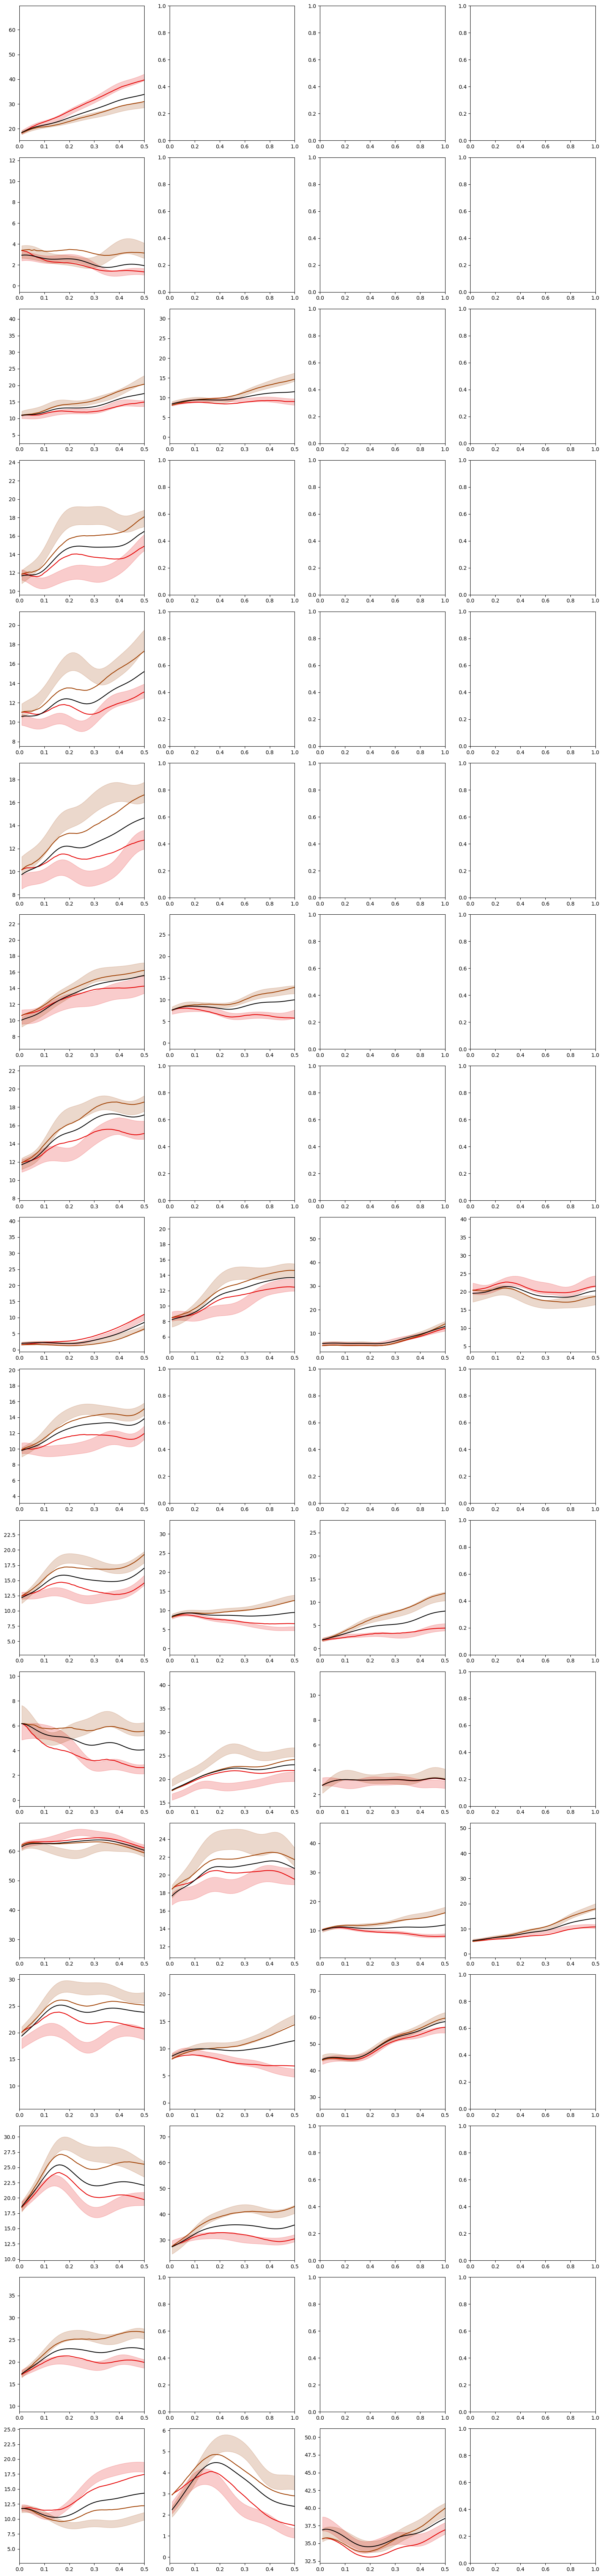

In [232]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]
#PPC colors = ["#1822A0","#5D4A7A","#A37354","#E99C2F"]
#STR colors = ["#A01892","#B85C71","#D0A150","#E9E62F"]

for i in 1:num_rows      
    for j in 1:data[i][1].ncells   
        
        if (num_rows == 1) && (data[i][1].ncells == 1)
        
            for k = 1:nconds   

                ax.fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k]) 
                
                ax.plot((1:length(μ_c_λ[i][j][k]))*dt,
                    μ_c_λ[i][j][k], color=my_colors[k])  

                ax.set_xlim((0, 0.5))

            end   

            ax.plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
            
        elseif (num_rows == 1) && (data[i][1].ncells > 1)
            
            for k = 1:nconds   

                ax[j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])  
                
                ax[j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                    μ_c_λ[i][j][k], color=my_colors[k])  

                ax[j].set_xlim((0, 0.5))

            end   

            ax[j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        elseif num_rows > 1
             
            for k = 1:nconds   

                ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k]) 
                
                ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                    μ_c_λ[i][j][k], color=my_colors[k])  

                ax[i,j].set_xlim((0, 0.5))

            end   

            ax[i,j].plot((1:length(μ_t[i][j]))*dt,
                μ_t[i][j], color="black")
            
        end

    end
    
end

tight_layout() 

In [108]:
SSx(x, nT) = sum(sum.(map(x-> x[1:nT].^2, vcat(vcat((x)...)...)))) 

SSx (generic function with 1 method)

In [ ]:
SSx(x, nT) = sum(sum.(map(x-> x[1:nT].^2, vcat(vcat((x)...)...)))) 

In [137]:
using Statistics: mean

In [233]:
blah = μ_λ - μ_rnt;

In [234]:
blah2 = [[sum([sum((blah[s][r][n][1:40]).^2) for r in 1:length(blah[s])]) 
        for n in 1:length(blah[s][1])] for s in 1:length(blah)];

In [235]:
blah3 = [[sum([sum((μ_rnt[s][r][n][1:40]).^2) for r in 1:length(μ_rnt[s])]) 
        for n in 1:length(μ_rnt[s][1])] for s in 1:length(μ_rnt)];

In [236]:
blah4 = [[1 - (blah2[s][n]/blah3[s][n]) for n in 1:length(blah2[s])] for s in 1:length(blah2)]

17-element Array{Array{Float64,1},1}:
 [0.8728072687776521]                                                              
 [0.2385834588026614]                                                              
 [0.7496540777441995, 0.7887746585519922]                                          
 [0.7688388620845995]                                                              
 [0.7212973566384495]                                                              
 [0.7355006901851364]                                                              
 [0.7643911053783332, 0.684229820866425]                                           
 [0.7522418040011447]                                                              
 [0.24208920752389107, 0.7108987796031488, 0.49093898750733467, 0.7024111265437325]
 [0.7358916252885386]                                                              
 [0.7780662675100399, 0.7430651465066392, 0.3770885141188284]                      
 [0.40351844047319674, 0.8211082781583

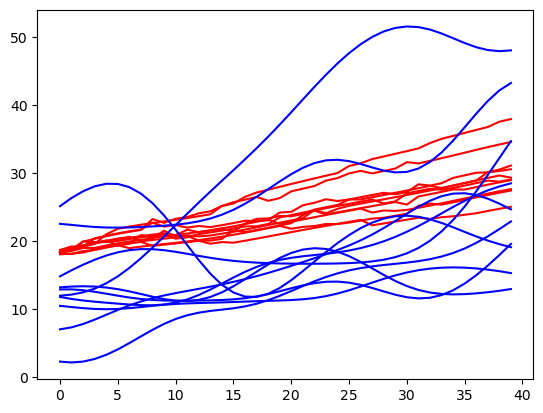

10-element Array{Array{PyCall.PyObject,1},1}:
 [PyObject <matplotlib.lines.Line2D object at 0x7f6503f76160>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f652ef38128>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f652ef38278>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f653a124e48>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f64ef5d3f60>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f64ef5d36d8>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f64ef5d36a0>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f64ef5d34a8>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f64ef5b7b38>]
 [PyObject <matplotlib.lines.Line2D object at 0x7f64ef5b7ba8>]

In [237]:
plot.([μ_λ[1][r][1][1:40] for r in 1:10], color="red")
plot.([μ_rnt[1][r][1][1:40] for r in 1:10], color="blue")

In [129]:
1 - SSx(μ_λ - μ_rnt, 40)/SSx(μ_rnt, 40)

0.85258056631619

In [109]:
1 - SSx(μ_c_λ - μ_ct, 40)/SSx(μ_ct, 40)

0.9970826704894704

### Compute Hessian
Blah blah blah

In [110]:
H = Hessian(model, n)
CI, HPSD = CIs(H);

┌ Warning: Hessian is not positive definite. Approximated by closest PSD matrix.
│             ||ϵ||/||H|| is 2.0000294512081
└ @ pulse_input_DDM /usr/people/briandd/Projects/pulse_input_DDM/src/base_model.jl:19


In [111]:
CI

143-element Array{Float64,1}:
  0.7162813712952799   
 11.829340948056137    
  0.3579494071664878   
  1.3614192531112701e-6
  1.2004674925286565   
  0.279972371808008    
  0.028180484407969265 
  1.8371628714633952   
  2.1789859220768113   
  0.16883458535909812  
  0.5774894840414927   
  0.6963695646180367   
  0.9418406786906962   
  ⋮                    
  1.0512447761053016   
  1.7021769434440361   
  0.2189239026938683   
  0.5044110273878102   
  0.5614888846427553   
  0.6793372837871762   
  1.8419495810226931   
  2.0000000000000004   
  1.4565349065595488   
  1.9999999999999938   
  0.2159138464348087   
  2.168744790827926    

In [112]:
pulse_input_DDM.flatten(model.θ)

143-element Array{Float64,1}:
  0.1                 
 27.466661699173294   
  2.406144673011837   
  1.253312858971242e-9
  1.8536495961385862  
  0.07053312345977117 
  0.04323787716300598 
 -8.760194230965475   
 18.716025248834065   
 -0.2949391674916836  
 -0.17153970037245522 
 -2.7328806880966523  
  4.751277551471047   
  ⋮                   
 -6.879369040642811   
 12.351915814338813   
 -0.3747190546259894  
  0.29993660327584815 
 -2.1780635368222043  
  3.59063748228514    
  1.5422994127344296  
  2.4550038671712735  
 -2.395698887792527   
 11.165479743828755   
  0.22078198900991777 
 -2.2660194546295833  

In [222]:
save_file = ENV["HOME"]*"/Projects/pulse_input_DDM/examples/bdd_work/"*rat*".mat"

"/usr/people/briandd/Projects/pulse_input_DDM/examples/bdd_work/T063.mat"

In [223]:
save(save_file, model, options, CI)